In [293]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import nltk
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('punkt')
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split


from sklearn.feature_extraction.text import TfidfVectorizer
import re
from nltk.stem.porter import PorterStemmer
import h2o
from h2o.automl import H2OAutoML
from sklearn.metrics import classification_report, confusion_matrix

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/rahulsound/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/rahulsound/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/rahulsound/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


## Helper Functions for Text cleaning::

In [56]:
import re
def decontracted(phrase):
  """decontracted takes text and convert contractions into natural form.
     ref: https://stackoverflow.com/questions/19790188/expanding-english-language-contractions-in-python/47091490#47091490"""

  # specific
  phrase = re.sub(r"won\'t", "will not", phrase)
  phrase = re.sub(r"can\'t", "can not", phrase)
  phrase = re.sub(r"won\’t", "will not", phrase)
  phrase = re.sub(r"can\’t", "can not", phrase)

  # general
  phrase = re.sub(r"n\'t", " not", phrase)
  phrase = re.sub(r"\'re", " are", phrase)
  phrase = re.sub(r"\'s", " is", phrase)
  phrase = re.sub(r"\'d", " would", phrase)
  phrase = re.sub(r"\'ll", " will", phrase)
  phrase = re.sub(r"\'t", " not", phrase)
  phrase = re.sub(r"\'ve", " have", phrase)
  phrase = re.sub(r"\'m", " am", phrase)

  phrase = re.sub(r"n\’t", " not", phrase)
  phrase = re.sub(r"\’re", " are", phrase)
  phrase = re.sub(r"\’s", " is", phrase)
  phrase = re.sub(r"\’d", " would", phrase)
  phrase = re.sub(r"\’ll", " will", phrase)
  phrase = re.sub(r"\’t", " not", phrase)
  phrase = re.sub(r"\’ve", " have", phrase)
  phrase = re.sub(r"\’m", " am", phrase)

  return phrase

#processed_text = decontracted(processed_text)
#print(processed_text)

def remove_special_character(phrase, remove_number=False):
  """remove_special_character takes text and removes special charcters.
     ref: https://stackoverflow.com/a/18082370/4084039"""

  phrase = re.sub("\S*\d\S*", "", phrase).strip()
  if remove_number:
    phrase = re.sub('[^A-Za-z]+', ' ', phrase)
  else:
    phrase = re.sub('[^A-Za-z0-9]+', ' ', phrase)
  return phrase

# processed_text = remove_special_character(processed_text, True)
# print(processed_text)

def remove_stop_words(text):
    stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', \
                "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', \
                'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", \
                'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', \
                'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', \
                'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', \
                'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
                'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', \
                'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', \
                'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', \
                'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'only', \
                'own', 'same', 'so', 'than', 'too', 'very', 's', 't', 'can', 'will', 'just', 'don', "don't", \
                'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', 've', 'y', 'ain', 'aren', "aren't", \
                'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn', "hadn't", 'hasn', \
                "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn', \
                "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", \
                'weren', "weren't", 'won', "won't", 'wouldn', "wouldn't"])
    return ' '.join(e.lower() for e in text.split() if e.lower() not in stopwords)

# ref: https://gist.github.com/sebleier/554280

# processed_text = ' '.join(e.lower() for e in processed_text.split() if e.lower() not in stopwords)
# print(processed_text)

def lemmatize_text(text_data):
  """lem_text takes text and lemmatize it using WordNetLemmatizer.
     ref: https://stackoverflow.com/a/25535348"""
  lem = WordNetLemmatizer()
  n_text = []
  for word in text_data.split(' '):
    n_word = lem.lemmatize(word, pos='a')
    n_word = lem.lemmatize(n_word, pos='v')
    n_text.append(n_word)

  return ' '.join(n_text)

# processed_text = lem_text(processed_text)
# print(processed_text)

def stem_and_stopwords(text):
    stemmer = nltk.stem.SnowballStemmer('english')
    stop_words = set(nltk.corpus.stopwords.words('english'))
    tokens = [word for word in nltk.word_tokenize(text) if (len(word) > 3 and len(word.strip('Xx/')) > 2 and len(re.sub('\d+', '', word.strip('Xx/'))) > 3) ] 
    tokens = map(str.lower, tokens)
    stems = [stemmer.stem(item) for item in tokens if (item not in stop_words)]
    return stems


def clean_text(text):
    text = decontracted(text)
    text = remove_special_character(text)
    text = remove_stop_words(text)
    text = lemmatize_text(text)
    text = stem_and_stopwords(text)
    return text

In [294]:
data = pd.read_csv('data.csv')

In [351]:
data.shape

(425, 12)

In [295]:
data.head(2)

,Unnamed: 0,Data,Countries,Local,Industry Sector,Accident Level,Potential Accident Level,Genre,Employee or Third Party,Critical Risk,Description
0,0,2016-01-01 00:00:00,Country_01,Local_01,Mining,I,IV,Male,Third Party,Pressed,"While removing the drill rod of the Jumbo 08 for maintenance, the ..."
1,1,2016-01-02 00:00:00,Country_02,Local_02,Mining,I,IV,Male,Employee,Pressurized Systems,"During the activation of a sodium sulphide pump, the piping was un..."


In [296]:
df = data[['Potential Accident Level', 'Description']]

In [297]:
df['Potential Accident Level'].astype('category')

0       IV
1       IV
2      III
3        I
4       IV
      ... 
420    III
421     II
422     II
423     II
424     II
Name: Potential Accident Level, Length: 425, dtype: category
Categories (6, object): [I, II, III, IV, V, VI]

In [298]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 425 entries, 0 to 424
Data columns (total 2 columns):
Potential Accident Level    425 non-null object
Description                 425 non-null object
dtypes: object(2)
memory usage: 6.8+ KB


In [299]:
df.Description = df.Description.apply(clean_text)

/Users/rahulsound/opt/anaconda3/lib/python3.7/site-packages/pandas/core/generic.py:5208: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [300]:
df.head(2)

,Potential Accident Level,Description
0,IV,"[remov, drill, jumbo, mainten, supervisor, proceed, loosen, suppor..."
1,IV,"[activ, sodium, sulphid, pump, uncoupl, sulfid, solut, design, are..."


In [301]:
X = df['Description']
y = df['Potential Accident Level']
X_train, X_test, y_train, y_test = train_test_split(X, y , test_size=0.2, random_state=111)


In [302]:
X_train[:20]

145    [employe, report, work, brushcutt, near, stone, blade, equip, coll...
265    [time, four, employe, lower, metal, sheet, toward, floor, height, ...
89     [clean, vertic, pipe, hydrojet, equip, high, pressur, hose, hose, ...
45     [time, assist, carri, cement, weigh, lamp, loader, suspend, floor,...
362    [employe, report, supervis, activ, ustul, near, ball, project, hum...
102    [jesus, oper, concret, throw, team, alpha, shoot, shotcret, work, ...
290    [deslamin, stop, untim, oper, lower, lock, machin, verifi, failur,...
361    [employe, report, assist, mainten, activ, tower, electrolysi, step...
154    [approxim, oper, paulo, oper, filter, inform, autoclav, oper, radi...
225    [approxim, marco, isidro, torr, perform, pipe, standard, moment, m...
77     [circumst, worker, abratech, compani, putti, work, insid, condit, ...
107    [employe, report, climb, access, ladder, oper, room, ustul, surpri...
96     [perform, clean, block, level, oper, surpris, rock, block, displac...

## Try plotting 20 rows::

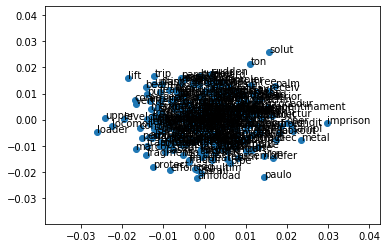

In [303]:
from gensim.models import Word2Vec
from sklearn.decomposition import PCA
from matplotlib import pyplot

sentences = X_train[:20]
# train model
model = Word2Vec(sentences, min_count=1)
# fit a 2d PCA model to the vectors
X = model.wv[model.wv.key_to_index]
pca = PCA(n_components=2)
result = pca.fit_transform(X)
# create a scatter plot of the projection
pyplot.scatter(result[:, 0], result[:, 1])
#words = list(model.wv.vocab)
words = list(model.wv.key_to_index)

for i, word in enumerate(words):
	pyplot.annotate(word, xy=(result[i, 0], result[i, 1]))
pyplot.show()

### To check other options : Try including other features like countries, industry etc. based on EDA findings...

---

### Try with H2o:


In [304]:
h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321 . connected.


H2O_cluster_uptime:,1 hour 27 mins
H2O_cluster_timezone:,Asia/Kolkata
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.32.1.1
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_rahulsound_ehsh2e
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,3.965 Gb
H2O_cluster_total_cores:,8
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


In [305]:
data.head(2)

,Unnamed: 0,Data,Countries,Local,Industry Sector,Accident Level,Potential Accident Level,Genre,Employee or Third Party,Critical Risk,Description
0,0,2016-01-01 00:00:00,Country_01,Local_01,Mining,I,IV,Male,Third Party,Pressed,"While removing the drill rod of the Jumbo 08 for maintenance, the ..."
1,1,2016-01-02 00:00:00,Country_02,Local_02,Mining,I,IV,Male,Employee,Pressurized Systems,"During the activation of a sodium sulphide pump, the piping was un..."


In [306]:

target={'I':0, 'II':1, 'III':2, 'IV':3, 'V':4, 'VI':5}
data['target']=data['Potential Accident Level'].map(target)



In [307]:
X_train, X_test = train_test_split(data[['Description', 'target']], test_size=0.2, random_state=111)

In [349]:
X_train.shape

(340, 2)

In [350]:
X_test.shape

(85, 2)

In [309]:
stemmer = nltk.stem.SnowballStemmer('english')
stop_words = set(nltk.corpus.stopwords.words('english'))

def tokenize(text):
   tokens = [word for word in nltk.word_tokenize(text) if (len(word) > 3 and len(word.strip('Xx/')) > 2 and len(re.sub('\d+', '', word.strip('Xx/'))) > 3) ] 
   tokens = map(str.lower, tokens)
   stems = [stemmer.stem(item) for item in tokens if (item not in stop_words)]
   return stems

In [310]:
vectorizer_tf = TfidfVectorizer(tokenizer=clean_text, stop_words=None, max_df=0.75, max_features=1000, lowercase=False, ngram_range=(1,2))
train_vectors = vectorizer_tf.fit_transform(X_train.Description) 

In [311]:
train_vectors.A

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.14748377, 0.        , ..., 0.        , 0.        ,
        0.        ]])

In [312]:
vectorizer_tf.get_feature_names()

['abrupt',
 'access',
 'accessori',
 'accid',
 'accid employe',
 'accid oper',
 'accid victim',
 'accid wear',
 'accid worker',
 'accommod',
 'accompani',
 'accumul',
 'acid',
 'across',
 'activ',
 'activ area',
 'activ chuteo',
 'activ employe',
 'activ paralyz',
 'activ remov',
 'advanc',
 'affect',
 'ahead',
 'ahead team',
 'allerg',
 'allerg reaction',
 'allergi',
 'alon',
 'alpha',
 'alreadi',
 'ampoload',
 'ampoload team',
 'anchor',
 'anfoload',
 'ankl',
 'anoth',
 'appear',
 'appear presenc',
 'approach',
 'approx',
 'approx impact',
 'approxim',
 'approxim circumst',
 'approxim meter',
 'approxim oper',
 'area',
 'around',
 'arrang',
 'arriv',
 'assembl',
 'assist',
 'assist posit',
 'atlas',
 'attack',
 'attack maribondo',
 'attempt',
 'attempt remov',
 'attend',
 'attent',
 'autoclav',
 'auxiliari',
 'avoid',
 'avoid fall',
 'away',
 'away area',
 'away place',
 'back',
 'back leav',
 'back right',
 'backward',
 'balanc',
 'balanc fall',
 'bank',
 'base',
 'basket',
 'beam',

In [313]:
test_vectors = vectorizer_tf.transform(X_test.Description)

In [314]:
train_df=pd.DataFrame(train_vectors.toarray(), columns=vectorizer_tf.get_feature_names())
train_df=pd.concat([train_df,X_train['target'].reset_index(drop=True)], axis=1)
train_df

,abrupt,access,accessori,accid,accid employe,accid oper,accid victim,accid wear,accid worker,accommod,...,worker prepar,worker time,worker wear,workshop,would,wrench,wrist,zinc,zone,target
0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,2
1,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,2
2,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,2
3,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,2
4,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
335,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,1
336,0.0,0.000000,0.0,0.110231,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.357063,0.0,0.0,0.0,0.0,0.0,3
337,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,3
338,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,2


In [315]:
test_df=pd.DataFrame(test_vectors.toarray(), columns=vectorizer_tf.get_feature_names())
test_df=pd.concat([test_df,X_test['target'].reset_index(drop=True)], axis=1)
test_df

,abrupt,access,accessori,accid,accid employe,accid oper,accid victim,accid wear,accid worker,accommod,...,worker prepar,worker time,worker wear,workshop,would,wrench,wrist,zinc,zone,target
0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,2
1,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,3
2,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,2
3,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.177942,0.0,3
4,0.0,0.096071,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.126369,0.0,0.0,0.000000,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
80,0.0,0.000000,0.0,0.107731,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,4
81,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,3
82,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,2
83,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,2


In [316]:
h2o_train_df = h2o.H2OFrame(train_df)
h2o_test_df = h2o.H2OFrame(test_df)

H2OResponseError: Server error java.lang.IllegalArgumentException:
  Error: Found duplicate column name target
  Request: POST /3/Parse
    data: {'destination_frame': 'Key_Frame__upload_bedfea11de9ac27f73958dbb18304fde.hex', 'parse_type': 'CSV', 'separator': '44', 'check_header': '1', 'number_columns': '1001', 'chunk_size': '4194304', 'delete_on_done': 'True', 'blocking': 'False', 'column_types': '["Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric"]', 'single_quotes': 'False', 'column_names': '["abrupt","access","accessori","accid","accid employe","accid oper","accid victim","accid wear","accid worker","accommod","accompani","accumul","acid","across","activ","activ area","activ chuteo","activ employe","activ paralyz","activ remov","advanc","affect","ahead","ahead team","allerg","allerg reaction","allergi","alon","alpha","alreadi","ampoload","ampoload team","anchor","anfoload","ankl","anoth","appear","appear presenc","approach","approx","approx impact","approxim","approxim circumst","approxim meter","approxim oper","area","around","arrang","arriv","assembl","assist","assist posit","atlas","attack","attack maribondo","attempt","attempt remov","attend","attent","autoclav","auxiliari","avoid","avoid fall","away","away area","away place","back","back leav","back right","backward","balanc","balanc fall","bank","base","basket","beam","bear","begin","behind","belt","belt collabor","bend","bite","blade","blast","block","block rock","blow","blunt","board","bodi","boiler","bolt","boltec","bolter","boot","bottom","brace","brake","branch","branch attack","break","break caus","bruis","bucket","bump","burn","cabin","cabl","calf","call","camera","canva","care","carri","carri activ","carri inspect","carri maneuv","cart","catch","cathod","cathod sheet","caus","caus blunt","caus bruis","caus contus","caus describ","caus fall","caus injuri","caus irrit","caus minor","caus slight","caus superfici","caus wind","cell","cement","center","central","chain","chamber","chang","channel","check","cheekbon","chest","chimney","chin","chin strap","chisel","chute","chuteo","chuteo hopper","circumst","circumst oper","circumst worker","citi","clamp","clean","clean activ","clean materi","clear","clerk","clerk wear","climb","close","cloth","coil","collabor","collabor perform","collabor time","collect","collect point","come","come across","come contact","communic","compani","compani carri","complet","compos","compress","concret","condit","connect","contact","contain","continu","continu activ","continu work","control","contus","conveyor","conveyor belt","convoy","cook","coordin","correct","correspond","corrug","corrug iron","could","coupl","cover","crane","cross","crown","cutter","cylind","danillo","day","decid","deep","degre","degre burn","descend","describ","describ injuri","describ time","design","detach","diamet","direct","direct flow","disassembl","discharg","discomfort","dismantl","displac","distal","distanc","divin","doctor","door","drainag","drill","drill assist","drill drill","drill machin","driller","drive","driver","drop","dust","easel","edg","effect","effort","electr","electr cabl","electrician","electrolysi","electroweld","electroweld mesh","emb","emerg","employe","employe insid","employe perform","employe rafael","employe refer","employe remov","employe report","employe take","empti","energ","engin","enter","enter forest","entranc","epp","equip","equip anfoload","equip hopper","equip oper","escap","evacu","evacu medic","evalu","event","excav","excess","exchang","execut","exert","explos","extens","fabio","face","face caus","fall","fall floor","fall height","fall insid","fall level","fall rock","fals","feeder","feel","feel pain","feet","felip","fell","felt","fenc","fenc area","field","fifth","fill","fill first","filter","final","find","finger","finger leav","finger press","finger right","finish","fire","first","first moment","flang","flash","floor","floor caus","floor grate","floor level","flow","flow cover","flow sudden","follow","foot","foot caus","forc","forearm","forehead","forest","forklift","form","forward","four","fourth","fourth finger","fractur","fragment","fragment personnel","fragment rock","frame","free","friction","front","full","furnac","gabl","galleri","gate","general","generat","generat describ","generat injuri","generat lesion","generat movement","geolog","give","give access","glass","glove","glove type","grate","grate grate","grid","grind","guard","guillotin","gutter","hammer","hand","hand caus","hand edg","hand generat","hand glove","hand oper","hand time","handl","happen","hdpe","head","hear","hear nois","heat","heavi","heavi equip","height","height meter","helic","helmet","helmet safeti","help","helper","high","hoist","hold","hold right","holder","hole","hook","hopper","hopper fill","hopper oper","horizont","hors","hose","hospit","hospit medic","hour","hous","hydraul","identifi","immedi","impact","impact face","impact leav","impact right","imprison","inch","incid","incimmet","inclin","includ","index","index finger","indic","inform","ingot","initi","injur","injur person","injur worker","injuri","injuri describ","injuri leav","injuri time","injuri worker","inner","insid","insid tank","inspect","instal","instant","intern","intersect","involv","iron","irrit","jumbo","knee","ladder","lamp","last","late","launch","leach","leak","lean","leather","leather glove","leav","leav area","leav caus","leav foot","leav forearm","leav gabl","leav hand","leav side","leav uniform","leav work","leg","len","length","lens","lesion","lesion describ","level","level access","level oper","lever","lift","light","limb","line","line fire","liquid","liquid zinc","littl","littl finger","load","load activ","load explos","load flow","loader","local","local swell","locat","lock","locomot","locomot park","long","look","loos","loosen","lose","lose balanc","loud","loud sound","lower","lubric","lunch","machet","machin","magnetometr","maid","main","mainten","make","make safeti","manag","maneuv","manipul","manoel","manoel silva","manual","marco","maribondo","mark","master","master loader","materi","materi fell","mean","mechan","mechan technician","medic","medic care","medic center","medic post","medic servic","member","mesh","mesh impact","metal","metal grate","metal structur","metal tube","meter","meter deep","meter floor","meter high","meter oper","meter time","middl","middl finger","mild","mill","mine","mine technician","miner","minor","mixkret","moment","moment blow","moment collabor","moment oper","motor","mouth","move","move away","move collect","move direct","movement","nail","near","near grind","necessari","neck","neck quick","need","next","nois","normal","normal activ","note","notic","observ","obstruct","occur","offic","offici","onto","open","open access","oper","oper assist","oper locomot","oper notic","oper perform","oper scissor","oper stop","order","origin","orlando","oven","overflow","pain","paint","palm","palm leav","paracatu","paralyz","park","park equip","part","particl","partner","pass","patrol","paulo","peopl","perceiv","perfor","perform","perform activ","perform clean","perform mainten","perform soil","person","personnel","personnel direct","phase","pick","piec","piec rock","pierc","pilot","pipe","pipe diamet","place","place clerk","plant","plat","plate","platform","platform floor","plug","point","point anoth","pole","polyethylen","polyethylen pipe","polym","posit","possibl","post","power","prepar","presenc","presenc rock","present","press","press finger","press leav","press right","pressur","prevent","previous","prick","probe","problem","proceed","proceed remov","process","produc","produc injuri","produc slight","product","project","project face","project onto","project pulp","project toward","protect","protector","protrud","pull","pulley","pulp","pump","pump pipe","push","quick","quirodactyl","radial","radio","rafael","rail","rais","ramp","reach","reach leav","reaction","reaction continu","reaction return","realiz","rear","rebound","receiv","reconnaiss","recoveri","recoveri boiler","reduc","refer","refer medic","region","releas","releas load","remain","remov","report","report perform","resid","residu","respons","rest","result","retir","return","return initi","return normal","rice","right","right caus","right foot","right forearm","right gabl","right hand","right knee","right side","right worker","ring","ring finger","road","robson","robson manoel","rock","rock approx","rock fragment","rod","roll","roof","roof work","room","rope","rotat","rotat unit","routin","routin activ","rubber","rubber glove","ruptur","safeti","safeti belt","safeti boot","safeti glass","safeti glove","safeti helmet","safeti len","sampl","scaffold","scissor","scissor bolter","scoop","scooptram","screen","seat","second","second finger","section","servic","sever","shank","shape","shear","sheet","shift","shock","shotcret","shoulder","shoulder caus","side","side equip","silva","silva attack","sinc","sink","site","sleev","slide","slight","slip","slip hand","slop","slope","small","soil","soil collect","soil sampl","sole","solut","soon","sound","south","spill","splash","split","squar","squat","staff","stage","staircas","stand","start","station","steel","steel plate","step","step fall","step fals","stick","still","stilson","sting","stone","stool","stop","stop vehicl","storm","strap","strike","strip","structur","structur caus","stumbl","stump","suction","sudden","sudden appear","suffer","suffer sting","sulfur","sulfur acid","superfici","superfici injuri","supervis","supervis activ","supervisor","support","support mesh","surfac","surpris","surpris swarm","survey","suspend","sustain","swarm","swell","system","tabl","tail","tail pulley","take","take bite","take hospit","tank","target","task","team","team compos","technician","telescop","tell","tension","test","thermal","thermal recoveri","third","third finger","thorn","three","throw","thumb","tilt","time","time accid","time event","time incid","time worker","tipper","tire","togeth","tool","toward","tower","track","transfer","transfer medic","transit","transmiss","transmiss belt","transport","transvers","trap","travel","treat","truck","truck leav","truck oper","truck park","tube","turn","twist","twist leav","type","type allerg","type safeti","unbal","uniform","unit","unload","unlock","untim","upon","upper","upper part","ustul","valv","veget","vehicl","vehicl move","ventil","verifi","verifi type","vertic","victim","visit","visual","wagon","walk","wall","warehous","wash","wasp","wast","water","wear","wear glove","wear safeti","weigh","weight","weld","weld work","welder","well","wheel","wick","william","winch","wind","window","wire","withdraw","without","without notic","wood","wooden","wooden block","work","work area","work normal","worker","worker caus","worker compani","worker decid","worker helmet","worker prepar","worker time","worker wear","workshop","would","wrench","wrist","zinc","zone","target"]', 'source_frames': '["upload_bedfea11de9ac27f73958dbb18304fde"]'}


In [317]:
h2o_train_df.types

{'abrupt': 'real',
 'access': 'real',
 'accessori': 'real',
 'accid': 'real',
 'accid employe': 'real',
 'accid oper': 'real',
 'accid victim': 'real',
 'accid wear': 'real',
 'accid worker': 'real',
 'accommod': 'real',
 'accompani': 'real',
 'accumul': 'real',
 'acid': 'real',
 'across': 'real',
 'activ': 'real',
 'activ area': 'real',
 'activ chuteo': 'real',
 'activ employe': 'real',
 'activ paralyz': 'real',
 'activ remov': 'real',
 'advanc': 'real',
 'affect': 'real',
 'ahead': 'real',
 'ahead team': 'real',
 'allerg': 'real',
 'allerg reaction': 'real',
 'allergi': 'real',
 'alon': 'real',
 'alpha': 'real',
 'alreadi': 'real',
 'ampoload': 'real',
 'ampoload team': 'real',
 'anchor': 'real',
 'anfoload': 'real',
 'ankl': 'real',
 'anoth': 'real',
 'appear': 'real',
 'appear presenc': 'real',
 'approach': 'real',
 'approx': 'real',
 'approx impact': 'real',
 'approxim': 'real',
 'approxim circumst': 'real',
 'approxim meter': 'real',
 'approxim oper': 'real',
 'area': 'real',
 'a

In [318]:
h2o_train_df['Potential Accident Level'] = h2o_train_df['Potential Accident Level'].asfactor()
h2o_test_df['Potential Accident Level'] = h2o_test_df['Potential Accident Level'].asfactor()

In [319]:
aml = H2OAutoML(max_models = 10, seed = 10, exclude_algos = ["StackedEnsemble"], verbosity="info", nfolds=0, balance_classes=True, max_after_balance_size=0.3)

In [320]:
x=vectorizer_tf.get_feature_names()
y='target'

In [321]:
aml.train(x = x, y = y, training_frame = h2o_train_df, validation_frame=h2o_test_df)

AutoML progress: |
09:17:14.97: Project: AutoML_20210327_91714096
09:17:14.97: Cross-validation disabled by user: no fold column nor nfolds > 1.
09:17:14.97: Setting stopping tolerance adaptively based on the training frame: 0.05
09:17:14.97: Build control seed: 10
09:17:14.98: Since cross-validation is disabled, and no leaderboard frame was provided, automatically split the training data into training and leaderboard frames in the ratio 90/10
09:17:14.153: training frame: Frame key: automl_training_py_182_sid_a462    cols: 1001    rows: 305  chunks: 1    size: 182189  checksum: 6884288376341849602
09:17:14.153: validation frame: Frame key: py_183_sid_a462    cols: 1001    rows: 85  chunks: 1    size: 104595  checksum: -4346255285426696545
09:17:14.158: leaderboard frame: Frame key: automl_leaderboard_py_182_sid_a462    cols: 1001    rows: 35  chunks: 1    size: 90319  checksum: -323532455171295187
09:17:14.158: blending frame: NULL
09:17:14.158: response column: target
09:17:14.158: f

In [322]:
aml.leaderboard

model_id,mean_residual_deviance,rmse,mse,mae,rmsle
GBM_5_AutoML_20210327_091714,8.79639e-06,0.00296587,8.79639e-06,0.00275189,0.0029608
GBM_3_AutoML_20210327_091714,3.4313e-05,0.00585773,3.4313e-05,0.00461405,0.00585761
GBM_4_AutoML_20210327_091714,3.78955e-05,0.00615593,3.78955e-05,0.00447691,0.00614913
GBM_2_AutoML_20210327_091714,4.04954e-05,0.0063636,4.04954e-05,0.00515734,0.00636571
GBM_1_AutoML_20210327_091714,4.13124e-05,0.00642748,4.13124e-05,0.00176791,0.00634197
XGBoost_3_AutoML_20210327_091714,4.79696e-05,0.00692601,4.79696e-05,0.00270032,0.00681486
GLM_1_AutoML_20210327_091714,6.89557e-05,0.00830395,6.89557e-05,0.00541596,0.00825533
DRF_1_AutoML_20210327_091714,9.40702e-05,0.00969898,9.40702e-05,0.00245729,0.00946362
XGBoost_2_AutoML_20210327_091714,0.000100781,0.010039,0.000100781,0.0065582,0.00998466
XGBoost_1_AutoML_20210327_091714,0.00010596,0.0102937,0.00010596,0.0051106,0.0100865


In [323]:
pred=aml.leader.predict(h2o_test_df)

gbm prediction progress: |████████████████████████████████████████████████| 100%


In [324]:
aml.leader.model_performance(h2o_test_df)


ModelMetricsRegression: gbm
** Reported on test data. **

MSE: 0.00023148568599063647
RMSE: 0.015214653659897635
MAE: 0.004648725116631622
RMSLE: 0.014257293298484588
Mean Residual Deviance: 0.00023148568599063647


In [348]:
aml.leader.model_performance(h2o_train_df)


ModelMetricsRegression: gbm
** Reported on test data. **

MSE: 0.00039740516978979885
RMSE: 0.019935023696745355
MAE: 0.005257730101507206
RMSLE: 0.01841001609783976
Mean Residual Deviance: 0.00039740516978979885


In [325]:
aml.leader.model_performance

Model Details
H2OGradientBoostingEstimator :  Gradient Boosting Machine
Model Key:  GBM_5_AutoML_20210327_091714


Model Summary: 


,,number_of_trees,number_of_internal_trees,model_size_in_bytes,min_depth,max_depth,mean_depth,min_leaves,max_leaves,mean_leaves
0,,30.0,30.0,2445.0,1.0,1.0,0.766667,1.0,2.0,1.766667




ModelMetricsRegression: gbm
** Reported on train data. **

MSE: 0.0004419996201005104
RMSE: 0.021023787006638702
MAE: 0.0055452849998398395
RMSLE: 0.019411753519166762
Mean Residual Deviance: 0.0004419996201005104

ModelMetricsRegression: gbm
** Reported on validation data. **

MSE: 0.00023148568599063647
RMSE: 0.015214653659897635
MAE: 0.004648725116631622
RMSLE: 0.014257293298484588
Mean Residual Deviance: 0.00023148568599063647

Scoring History: 


,,timestamp,duration,number_of_trees,training_rmse,training_mae,training_deviance,validation_rmse,validation_mae,validation_deviance
0,,2021-03-27 09:17:34,0.006 sec,0.0,0.021151,0.005623,0.000447,0.015201,0.004454,0.000231
1,,2021-03-27 09:17:34,0.096 sec,5.0,0.021134,0.005500,0.000447,0.015209,0.004377,0.000231
2,,2021-03-27 09:17:34,0.162 sec,10.0,0.021114,0.005580,0.000446,0.015211,0.004517,0.000231
3,,2021-03-27 09:17:34,0.242 sec,15.0,0.021074,0.005533,0.000444,0.015210,0.004618,0.000231
4,,2021-03-27 09:17:34,0.326 sec,20.0,0.021053,0.005691,0.000443,0.015232,0.004863,0.000232
5,,2021-03-27 09:17:34,0.393 sec,25.0,0.021040,0.005665,0.000443,0.015236,0.004825,0.000232
6,,2021-03-27 09:17:34,0.473 sec,30.0,0.021024,0.005545,0.000442,0.015215,0.004649,0.000231



Variable Importances: 


,variable,relative_importance,scaled_importance,percentage
0,leav,0.008245,1.000000,0.973017
1,caus,0.000229,0.027731,0.026983
2,abrupt,0.000000,0.000000,0.000000
3,access,0.000000,0.000000,0.000000
4,accessori,0.000000,0.000000,0.000000
5,accid,0.000000,0.000000,0.000000
6,accid employe,0.000000,0.000000,0.000000
7,accid oper,0.000000,0.000000,0.000000
8,accid victim,0.000000,0.000000,0.000000
9,accid wear,0.000000,0.000000,0.000000



See the whole table with table.as_data_frame()


<bound method ModelBase.model_performance of >

In [326]:
model_ids = list(aml.leaderboard['model_id'].as_data_frame().iloc[:,0])
out = h2o.get_model([mid for mid in model_ids if "XGBoost" in mid][0])

In [327]:
out

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_3_AutoML_20210327_091714


Model Summary: 


,,number_of_trees
0,,50.0




ModelMetricsRegression: xgboost
** Reported on train data. **

MSE: 2.0698021277805797e-06
RMSE: 0.0014386806900005922
MAE: 0.00092372151671863
RMSLE: 0.0014091765900242689
Mean Residual Deviance: 2.0698021277805797e-06

ModelMetricsRegression: xgboost
** Reported on validation data. **

MSE: 4.385950459644928e-05
RMSE: 0.006622650873815506
MAE: 0.0032537554993348964
RMSLE: 0.006609988893787053
Mean Residual Deviance: 4.385950459644928e-05

Scoring History: 


,,timestamp,duration,number_of_trees,training_rmse,training_mae,training_deviance,validation_rmse,validation_mae,validation_deviance
0,,2021-03-27 09:17:16,0.005 sec,0.0,0.497582,0.497132,0.247588,0.498577,0.498347,0.248579
1,,2021-03-27 09:17:16,0.043 sec,5.0,0.085515,0.085075,0.007313,0.086148,0.085728,0.007421
2,,2021-03-27 09:17:16,0.061 sec,10.0,0.017105,0.015604,0.000293,0.017420,0.015892,0.000303
3,,2021-03-27 09:17:16,0.081 sec,15.0,0.007283,0.003671,0.000053,0.008114,0.004121,0.000066
4,,2021-03-27 09:17:16,0.108 sec,20.0,0.005223,0.002165,0.000027,0.007149,0.003133,0.000051
5,,2021-03-27 09:17:16,0.131 sec,25.0,0.003950,0.002024,0.000016,0.006510,0.003273,0.000042
6,,2021-03-27 09:17:16,0.152 sec,30.0,0.003129,0.001758,0.000010,0.006290,0.003174,0.000040
7,,2021-03-27 09:17:16,0.172 sec,35.0,0.002521,0.001528,0.000006,0.006220,0.003139,0.000039
8,,2021-03-27 09:17:16,0.194 sec,40.0,0.001980,0.001235,0.000004,0.006137,0.003145,0.000038
9,,2021-03-27 09:17:16,0.216 sec,45.0,0.001682,0.001070,0.000003,0.006465,0.003214,0.000042



Variable Importances: 


,variable,relative_importance,scaled_importance,percentage
0,field,0.054428,1.000000,0.237646
1,offici,0.040496,0.744033,0.176816
2,possibl,0.030769,0.565313,0.134344
3,collect point,0.026611,0.488925,0.116191
4,silva,0.010555,0.193929,0.046086
5,near,0.005403,0.099270,0.023591
6,nail,0.004967,0.091250,0.021685
7,board,0.004446,0.081680,0.019411
8,stump,0.004212,0.077383,0.018390
9,activ,0.003663,0.067302,0.015994



See the whole table with table.as_data_frame()


In [328]:
out.convert_H2OXGBoostParams_2_XGBoostParams()

({'silent': True,
  'eta': 0.3,
  'colsample_bylevel': 0.8,
  'objective': 'reg:squarederror',
  'min_child_weight': 3.0,
  'nthread': 8,
  'seed': 12,
  'max_depth': 5,
  'colsample_bytree': 0.8,
  'lambda': 1.0,
  'gamma': 0.0,
  'alpha': 0.0,
  'booster': 'gbtree',
  'grow_policy': 'depthwise',
  'nround': 10000,
  'subsample': 0.8,
  'max_delta_step': 0.0,
  'tree_method': 'exact'},
 10000)

In [329]:
import xgboost as xgb


In [330]:
xgb_clf = xgb.XGBClassifier(n_estimators=100, learning_rate=0.05, max_depth=6, objective='multi:softprob', random_state=10)

In [331]:
xgb_clf.fit(train_vectors, X_train['target'])

/Users/rahulsound/opt/anaconda3/lib/python3.7/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[09:17:39] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.05, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=8, num_parallel_tree=1,
              objective='multi:softprob', random_state=10, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=None, subsample=1,
              tree_method='exact', use_label_encoder=True,
              validate_parameters=1, verbosity=None)

In [332]:
predictions = xgb_clf.predict(test_vectors)

In [333]:
cm = confusion_matrix(X_test['target'], predictions)
print(cm)

[[ 4  1  2  3  0]
 [ 0  2  7  9  0]
 [ 0  9  5 12  0]
 [ 0  5  5 17  0]
 [ 0  1  1  2  0]]


In [334]:
print('classification_report :\n',classification_report(X_test['target'], predictions))

/Users/rahulsound/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


classification_report :
               precision    recall  f1-score   support

           0       1.00      0.40      0.57        10
           1       0.11      0.11      0.11        18
           2       0.25      0.19      0.22        26
           3       0.40      0.63      0.49        27
           4       0.00      0.00      0.00         4

    accuracy                           0.33        85
   macro avg       0.35      0.27      0.28        85
weighted avg       0.34      0.33      0.31        85



In [335]:
from sklearn.utils import class_weight
class_weights = list(class_weight.compute_class_weight('balanced',
                                             np.unique(X_train['target']),
                                             X_train['target']))

In [336]:
class_weights

[1.452991452991453,
 0.7359307359307359,
 0.7083333333333334,
 0.4885057471264368,
 2.0987654320987654,
 56.666666666666664]

In [337]:
weights = np.ones(X_train.shape[0], dtype = 'float')
weights

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1.

In [338]:
for i, val in enumerate(X_train['target']):
    weights[i] = class_weights[val]
weights

array([ 0.70833333,  0.70833333,  0.70833333,  0.70833333,  0.70833333,
        0.48850575,  0.70833333,  0.48850575,  2.09876543,  0.73593074,
        2.09876543,  0.48850575,  2.09876543,  0.48850575,  2.09876543,
        0.70833333,  0.73593074,  0.70833333,  0.48850575,  0.48850575,
        0.73593074,  0.48850575,  0.48850575,  0.48850575,  0.70833333,
        0.70833333,  2.09876543,  0.48850575,  1.45299145,  0.48850575,
        0.48850575,  1.45299145,  0.73593074,  0.70833333,  0.70833333,
        0.73593074,  0.48850575,  2.09876543,  0.73593074,  2.09876543,
        0.48850575,  0.48850575,  0.48850575,  0.48850575,  0.73593074,
        0.48850575,  0.73593074,  0.70833333,  0.48850575,  0.48850575,
        0.70833333,  0.48850575,  0.73593074,  0.73593074,  0.70833333,
        1.45299145,  1.45299145,  0.70833333,  0.48850575,  0.48850575,
        0.73593074,  1.45299145,  0.70833333,  0.70833333,  0.48850575,
        0.48850575,  0.48850575,  0.73593074,  0.73593074,  2.09

In [339]:
xgb_clf = xgb.XGBClassifier(n_estimators=100, learning_rate=0.05, max_depth=6, objective='multi:softprob', random_state=10)

In [340]:
xgb_clf.fit(train_vectors, X_train['target'], sample_weight=weights)

[09:17:40] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.05, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=8, num_parallel_tree=1,
              objective='multi:softprob', random_state=10, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=None, subsample=1,
              tree_method='exact', use_label_encoder=True,
              validate_parameters=1, verbosity=None)

In [341]:
predictions = xgb_clf.predict(test_vectors)

In [342]:
cm = confusion_matrix(X_test['target'], predictions)
print(cm)

[[ 4  3  3  0  0  0]
 [ 3  9  3  2  0  1]
 [ 0  8  8 10  0  0]
 [ 1  5  6 15  0  0]
 [ 0  1  1  2  0  0]
 [ 0  0  0  0  0  0]]


In [343]:
print('classification_report :\n',classification_report(X_test['target'], predictions))

/Users/rahulsound/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


classification_report :
               precision    recall  f1-score   support

           0       0.50      0.40      0.44        10
           1       0.35      0.50      0.41        18
           2       0.38      0.31      0.34        26
           3       0.52      0.56      0.54        27
           4       0.00      0.00      0.00         4
           5       0.00      0.00      0.00         0

    accuracy                           0.42        85
   macro avg       0.29      0.29      0.29        85
weighted avg       0.41      0.42      0.41        85

